In [24]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Color configuration for visualization
COLORS = {
    "True": "white",        # Alive cells
    "False": "black"        # Dead cells
}
GRID_COLOR = "gray"         # Color of the grid lines


def plot_grid(grid: np.ndarray) -> None:
    '''
    Plots the Game of Life grid using matplotlib.
    Args:
        grid (np.ndarray): 2D boolean array representing the grid state.
    '''

    # 1. Convert boolean matrix to 0-1 matrix and creation of personalized colormap
    grid_numeric = grid.astype(int)
    colors_list = [COLORS["False"], COLORS["True"]]
    cmap = mcolors.ListedColormap(colors_list)
    

    # 2. Calculate figure size based on grid dimensions for better visualization
    # First, get number of rows and columns and we define how big each cell should be
    rows, cols = grid.shape
    cell_size_inches = 1
    
    # Then we calculate width and height of the figure adding a small margin for 
    # title and axes
    w = cols * cell_size_inches + 1.5
    h = rows * cell_size_inches + 1.5
    
    # Finally, we limit the maximum size to avoid too large figures
    max_size = 6
    w = min(w, max_size)
    h = min(h, max_size)


    # 3. Visualization: we use imshow because it's very efficient for displaying 2D arrays
    # We add interpolation='nearest' to avoid blurring of the cells
    fig, ax = plt.subplots(figsize=(w,h))    
    img = ax.imshow(grid_numeric, cmap=cmap, interpolation='nearest')
    

    # 4. Aesthetic adjustments
    # First, we add grid lines to separate the cells using minor ticks and we plot them
    # -0.5 is used to center the grid lines between the cells
    ax.set_xticks(np.arange(-0.5, grid.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-0.5, grid.shape[0], 1), minor=True)    
    ax.grid(which='minor', color=GRID_COLOR, linestyle='-', linewidth=1)
    
    # Then, we remove the major ticks and labels for a cleaner look and we set the title
    # pad is used to add some space between title and grid
    ax.tick_params(which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    ax.set_title(f"Game of Life - Dimension: {rows}x{cols}", fontsize=15,
                 color='black', pad=20)
    plt.show()

    return None

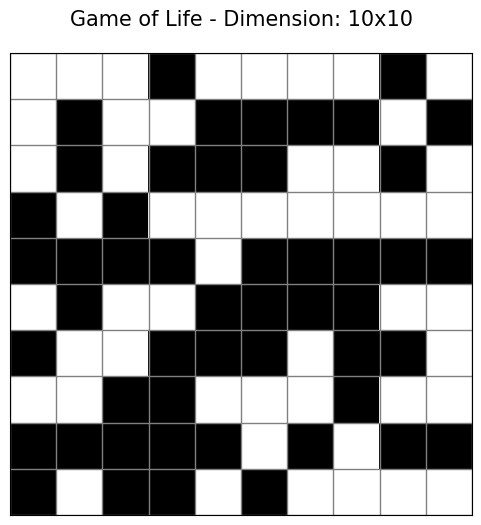

In [25]:
cells = np.random.choice(a=[True, False], size=(10, 10)) 
plot_grid(cells)

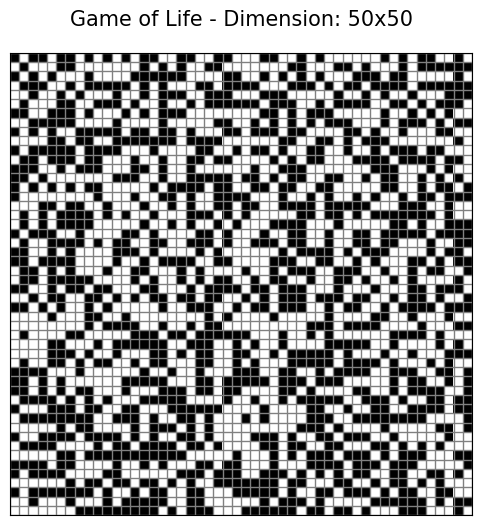

In [26]:
cells = np.random.choice(a=[True, False], size=(50, 50)) 
plot_grid(cells)